In [2]:
#Shucen Liu
#Assignment 2
#CMSC 25025
import pyspark.sql
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("mnist").getOrCreate()
df_prob3 = spark.read.json('/project/cmsc25025/mnist/data.json')

In [2]:
#helper functions
import numpy as np
from pyspark import SparkContext, SparkConf
from numpy.linalg import eigh
from pyspark.mllib.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.sql import Row
sc = spark.sparkContext

#Part1
def standardizedf(df):  #(a)
    """Standardize the data
        input: df:  A Spark dataframe with a column named 'features'.
        output: the dataframe (pipelined RDD) with all the data standardized
    """
    m = df.rdd.map(lambda x: np.array(x['features'])).mean()
    dfZeroMean = df.rdd.map(lambda x: np.array(x['features'])).map(lambda x: x-m)
    std = df.rdd.map(lambda x: np.array(x['features'])).stdev()
    dfStandard = dfZeroMean.map(lambda x: np.divide(x, std, out=np.zeros_like(x), where=std!=0))
    
    return dfStandard

def pca(df, k=10):  #(a)
    """Computes the top `k` principal components, the value of vectors w.r.t components, and all eigenvalues.

    Input:
        df: A Spark dataframe with a 'features' column.
        k (int): The number of principal components to return.
    Returns:
        the components (a list of top k eigenvectors), the value of vectors w.r.t components (pipelined rdd), 
        and all eigenvalues (list) 
     """
    df1 = standardizedf(df)
    cov = df1.map(lambda x: np.outer(x,x)).sum()/df1.count()
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]
    projection = df.rdd.map(lambda x: (x['features'], x['label'])).map(lambda x: (np.dot(x[0], components.T), x[1], x[0]) )

    return components.T, projection, eigVals

def calculate_proj(score, components): #(c)
    '''
    calculate the new vector using components and the value of vectors w.r.t components
    '''
    vector = np.array([0.0] * 784)
    for i in range(components.shape[1]):
        vector += score[i]*components[:,i]
    return vector

def find_error(scored_df, components): #(d)
    '''
    Given the rdd of vectors value corresponding to components, calculate the error
    '''
    error = scored_df.map(lambda x: np.sum(np.square(x[2] - calculate_proj(x[0], components)))).reduce(lambda a, b: a + b)
    return error

In [4]:
#Part1
standard = standardizedf(df_prob3)
eigvectors, projection, eigval = pca(df_prob3, 10)

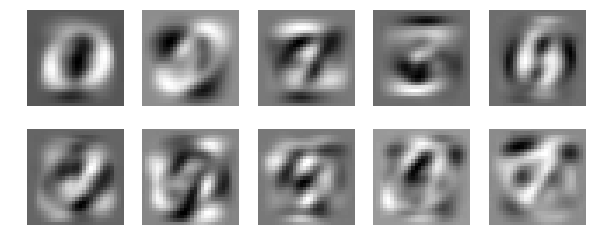

In [7]:
%matplotlib inline
#Part1 (a)
nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in xrange(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(eigvectors[:,i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

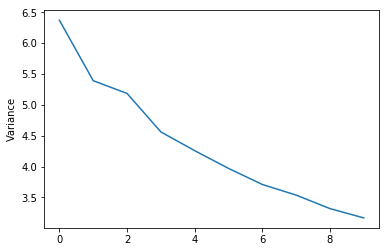

In [8]:
#Part1(b)
sigvals = np.sqrt(eigval[:10])
plt.plot(sigvals)
plt.ylabel('Variance')
plt.show()

10 principal components


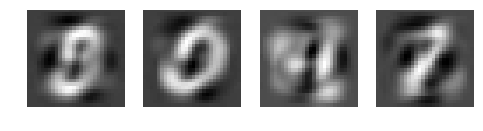

15 principal components


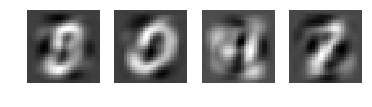

20 principal components


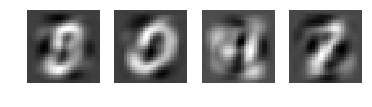

25 principal components


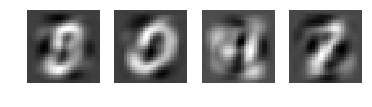

30 principal components


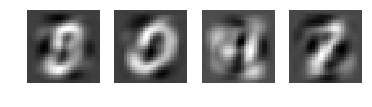

The results are OK, we can roughly identify the numbers after reconstruction.
As the number of principal components increase, the reconstructed images become more similar to the original ones.
The top principal components capture the major components that construct the original image.


In [10]:
#Part1(c)
nrows = 1
ncols = 4
plt.figure(figsize=(ncols * 2, nrows * 2))
for m in [10, 15, 20, 25, 30]:
    eigvectors_m, projection_m, eigval = pca(df_prob3, m)
    print str(m) + ' principal components'
    for i in [0, 1, 2 ,3]:
        projection_im = projection_m.take(5)[i][0]
        label_im = projection_m.take(5)[i][1]
        vector = np.array([0.0] * 784)
        for j in range(10):
            vector += projection_im[j]*eigvectors_m[:,j]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(vector.reshape((28,28)), cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()

print "The results are OK, we can roughly identify the numbers after reconstruction."
print "As the number of principal components increase, the reconstructed images become more similar to the original ones."
print "The top principal components capture the major components that construct the original image."

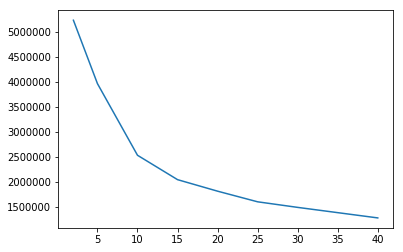

In [14]:
#Part1(d)

error_ls = []
m_ls = [2, 5, 10, 15, 20, 25, 30, 40]
for m in m_ls:
    components_m, projection_m, eigval = pca(df_prob3, m)
    error_m = find_error(projection_m, components_m)
    error_ls.append(error_m)

plt.plot(m_ls, error_ls)
plt.show()

In [15]:
#Part2
train, dev, test = df_prob3.rdd.randomSplit([4, 1, 1])
train_data = train.map(lambda x: np.array(x['features']))
clusters = KMeans.train(train_data, 10, maxIterations=50,
initializationMode="random")
df_clustered = df_prob3.rdd.map(lambda x: Row(cluster = clusters.predict(x['features']), features=x['features'], label=x['label']))

In [22]:
#Part2
clusteredschema = spark.createDataFrame(df_clustered)
clusteredschema.createOrReplaceTempView("clustered_data")
def label_clusters():
    '''
    label the clusters by associating it with the majority label
    '''
    groups = []
    labels = []
    for i in range(0, 10):
        query = str("SELECT cluster, label FROM clustered_data WHERE cluster = " + str(i))
        cluster = spark.sql(query)
        cluster.createOrReplaceTempView('cluster')
        label = spark.sql("SELECT label FROM cluster GROUP BY label ORDER BY COUNT(*) DESC LIMIT 1").rdd.map(lambda x: x['label'])
        labels.append(label.collect())
    return labels
labels = label_clusters()

This cluster has majority label8


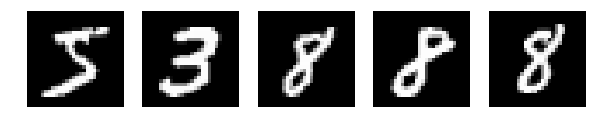

This cluster has majority label5


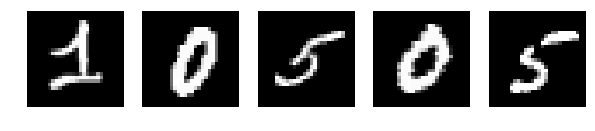

This cluster has majority label4


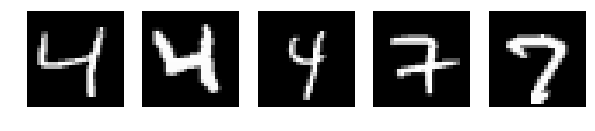

This cluster has majority label1


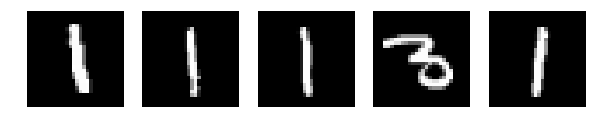

This cluster has majority label3


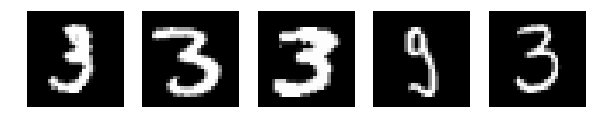

This cluster has majority label2


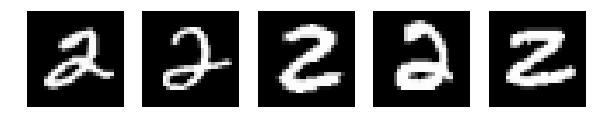

This cluster has majority label6


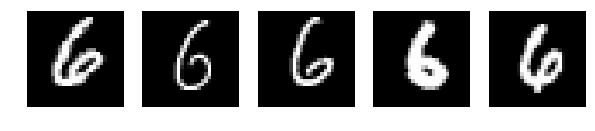

This cluster has majority label0


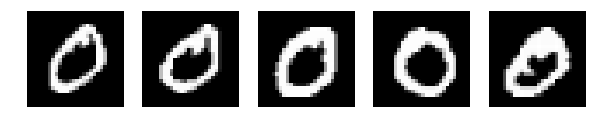

This cluster has majority label1


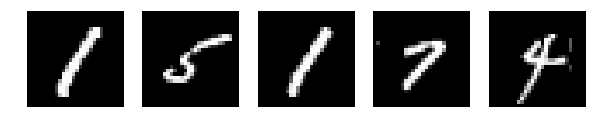

This cluster has majority label7


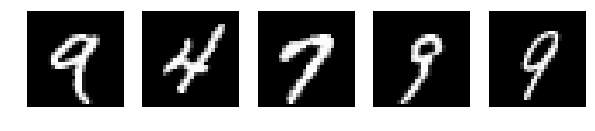

The clusters can represent the majority of the images with correct digit labels, but the error rate is not very low.


In [24]:
#Part2
import matplotlib.pyplot as plt
def select_digits(cluster_num):
    '''
    select 5 digits from a cluster, given the cluster number
    '''
    query = "SELECT features FROM clustered_data WHERE cluster = " + str(cluster_num)
    digits = spark.sql(query).collect()[:5]
    return digits

def plot_digits(digits):
    '''
    show the imgae of the selected digits
    '''
    nrows = 1
    ncols = 5
    plt.figure(figsize=(ncols*2, nrows*2))
    for i in range(len(digits)):
        vector = np.asarray(digits[i])
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(vector.reshape((28,28)), cmap='gray')     
        plt.axis('off')
    plt.axis('off')
    plt.show()    
for i in range(10):
    digits = select_digits(i)
    label = labels[i][0]
    print "This cluster has majority label" + str(label)
    plot_digits(digits)

print "The clusters can represent the majority of the images with correct digit labels, but the error rate is not very low." 

In [27]:
#Part3
from math import exp
import numpy as np
def compute_Gaussian(x, y, h):
    '''
    x, y numpy array (vectors), h: parameter
    compute the similarity between two row vectors
    '''
    g_sum = np.sum(np.square(x - y))
    kernel = exp(-g_sum/h)
    return kernel
training = df_prob3.rdd.randomSplit(weights = [0.1, 0.9], seed = 1)[0]
pairs = training.cartesian(training)
similar_ls = pairs.map(lambda x: compute_Gaussian(np.array(x[0]['features']), np.array(x[1]['features']), 0.4)).collect()


In [28]:
print len(similar_ls)

47623801


In [35]:
#Part3
num_col = len(similar_ls)^(1/2)
similarity_matrix = np.reshape(np.array(similar_ls), (num_col, num_col)) 
#sometimes the length of the list does not return a proper value. 
#if not, please hardcoded the size of the matrix as printed. Sorry for the trouble!
D_val = sc.parallelize(similarity_matrix).map(lambda x: float(np.sum(x))**(-1/2)).collect()
D_matrix = np.diagflat(D_val)
L_matrix = np.identity(num_col) - np.dot(np.dot(D_matrix, similarity_matrix), D_matrix)
eigVals, eigVecs = eigh(L_matrix)
last = eigVecs[-1]
last_3 = eigVecs[-4:-1]
digits = last_3.T
print "The spectrum of L is the same as the spectrum of A."
print "The last eigenvector is", last

The spectrum of L is the same as the spectrum of A.
The last eigenvector is [ -2.82837950e-27   3.97871834e-24  -1.44951112e-27 ...,   1.40055162e-27
   5.05004225e-25   6.01885093e-26]


This is cluster0


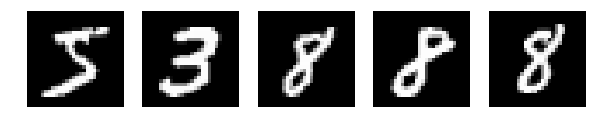

This is cluster1


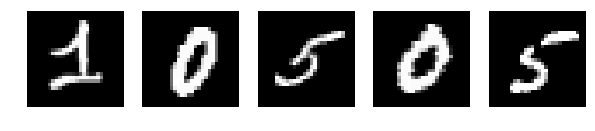

This is cluster2


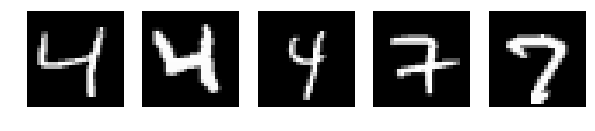

This is cluster3


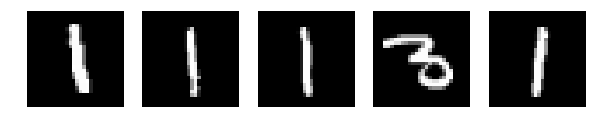

This is cluster4


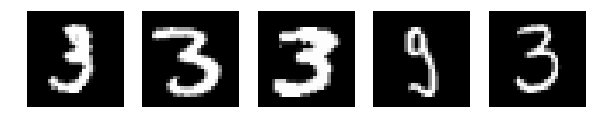

This is cluster5


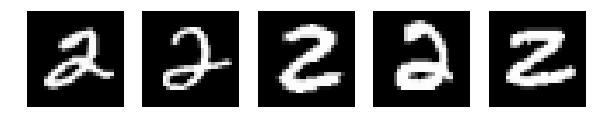

This is cluster6


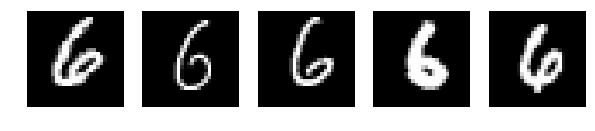

This is cluster7


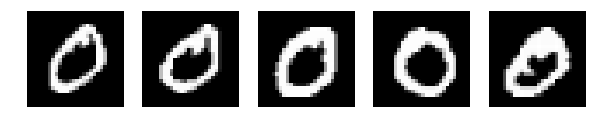

This is cluster8


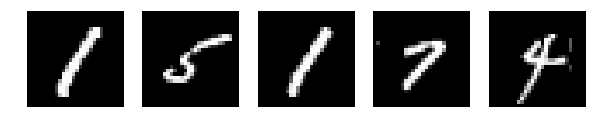

This is cluster9


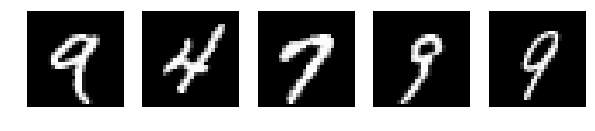

The results are almost the same as standard k-means


In [36]:
#Part3
clusters = KMeans.train(sc.parallelize(digits), 10, maxIterations=50, initializationMode="random")
for i in range(10):
    digits_ls = select_digits(i)
    print "This is cluster" + str(i)
    plot_digits(digits_ls)
print "The results are almost the same as standard k-means"

In [37]:
#Part4
train, dev, test = df_prob3.rdd.randomSplit([4, 1, 1])
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
labeled = train.map(lambda x : LabeledPoint(x["label"],x["features"]))
model = LogisticRegressionWithLBFGS.train(data = labeled, iterations = 10, numClasses = 10)

In [39]:
#(a)
def if_error(x):
    if x[1] == x[0]:
        return 0
    else:
        return 1
def find_error(dev, model):
    errors = dev.map(lambda x: (model.predict(x['features']), x['label'])).map(lambda x: if_error(x)).reduce(lambda a, b: a + b)
    error_rate = float(errors)/dev.count()
    return error_rate
error_rate = find_error(dev, model)
print "The error rate is ", error_rate*100, "%"

 The error rate is  12.2286295794 %


The error first drops as k increases, but later increases when k becomes very large


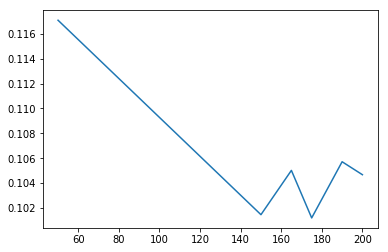

In [40]:
#(b)
standard = standardizedf(df_prob3)
def find_pca_error(df, k):
    components, projection, eigval = pca(df, k)
    train, dev, test = projection.randomSplit([4, 1, 1], seed = 1)
    labeled = train.map(lambda x : LabeledPoint(x[1],calculate_proj(x[0], components)))
    model = LogisticRegressionWithLBFGS.train(data = labeled, iterations = 10, numClasses = 10)
    dev_projected = dev.map(lambda x: (calculate_proj(x[0], components), x[1]))
    errors = dev_projected.map(lambda x: (model.predict(x[0]), x[1])).map(lambda x: if_error(x)).reduce(lambda a, b: a + b)
    error_rate = float(errors)/dev.count()
    return error_rate
k_ls = [50, 100, 150, 165, 175, 190, 200] #I have tried k with smaller values, but did not find this curve shape
err_ls = []
for k in k_ls:
    error = find_pca_error(df_prob3, k)
    err_ls.append(error)
plt.plot(k_ls, err_ls)    

print "The error first drops as k increases, but later increases when k becomes very large"

In [41]:
print err_ls

[0.11709988698600365, 0.10927584108493436, 0.10145179518386507, 0.10501608276101887, 0.10119099365382944, 0.10571155350778058, 0.10466834738763801]


In [42]:
#(c)
k = 170
components, projection, eigval = pca(df_prob3, k)
train, dev, test = projection.randomSplit([4, 1, 1], seed = 1)
new_train = train.union(dev)
labeled = train.map(lambda x : LabeledPoint(x[1],calculate_proj(x[0], components)))
model = LogisticRegressionWithLBFGS.train(data = labeled, iterations = 10, numClasses = 10)
test_projected = test.map(lambda x: (calculate_proj(x[0], components), x[1]))
errors = test_projected.map(lambda x: (model.predict(x[0]), x[1])).map(lambda x: if_error(x)).reduce(lambda a, b: a + b)
error_rate = float(errors)/dev.count() * 100

print "The error rate is ", error_rate, "%"
print "The error rate is smaller than regression using raw features."

The error rate is  10.3885942798 %
The error rate is smaller than regression using raw features.
